In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer,BertForMaskedLM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from tqdm import tqdm
#from early_stopping import EarlyStopping
import string
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
import re
from bs4 import BeautifulSoup

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        data = data.reset_index()
        self.tokenizer = tokenizer
        self.text = data.text
        self.targets = data.targets
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [4]:
class DistillBERTForRegression(torch.nn.Module):
    def __init__(self, layer_size=768, dropout=0.3):
        super(DistillBERTForRegression, self).__init__()
        self.bert = BertModel.from_pretrained("../jimharrington.johnselvynnallathambi/amd_bert-base-uncased")
        #self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.hidden_layer = torch.nn.Linear(768, layer_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(layer_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # BERT "pooling": https://github.com/huggingface/transformers/issues/1535
        bert_output = output_1[0][:, 0]
        x = self.hidden_layer(bert_output)
        x = torch.nn.ReLU()(x)
        # With dropout
        x = self.dropout(x)
        # Final layer
        x = self.classifier(x)
        return torch.nn.ReLU()(x)

    def eval_with_dict(self, data):
        return self(
            data['input_ids'].to(device, dtype=torch.long),
            data['attention_mask'].to(device, dtype=torch.long),
            data['token_type_ids'].to(device, dtype=torch.long)
        ).squeeze(1)

    def eval_with_loader(self, loader):
        self.eval()
        fin_targets = []
        fin_outputs = []
        with torch.no_grad():
            for _, data in enumerate(loader, 0):
                predictions = self.eval_with_dict(data)
                fin_targets.extend(data['targets'].tolist())
                fin_outputs.extend(predictions.to("cpu").detach().numpy().tolist())
        return fin_outputs, fin_targets


def compute_abs_error(predictions, targets, scaler):
    return torch.abs(
        untransform(predictions, scaler) - untransform(targets, scaler)
    ).sum().data


def untransform(y, scaler):
    return ( y * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0])

In [5]:
class Trainer:
    def __init__(self, dataset, tokenizer, learning_rate, patience, train_batch_size, test_batch_size):
        self.tokenizer = tokenizer
        self.learning_rate = learning_rate
        self.patience = patience
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.max_length = tokenizer.model_max_length
        self.loss = torch.nn.MSELoss()

        self.prepare_data(dataset)

    def prepare_data(self, dataset):
        train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, random_state=0)
        test_dataset, valid_dataset = train_test_split(test_dataset, test_size=0.2, random_state=0)

        # Normalization
        self.scaler = MinMaxScaler()
        self.scaler.fit(train_dataset[['targets']])
        train_dataset['targets'] = self.scaler.transform(train_dataset[['targets']])
        test_dataset['targets'] = self.scaler.transform(test_dataset[['targets']])
        valid_dataset['targets'] = self.scaler.transform(valid_dataset[['targets']])

        # Create datasets
        training_set = CustomDataset(train_dataset, self.tokenizer, self.max_length)
        test_set = CustomDataset(test_dataset, self.tokenizer, self.max_length)
        valid_set = CustomDataset(valid_dataset, self.tokenizer, self.max_length)

        # Create data loaders
        train_params = {
            'batch_size': self.train_batch_size,
            'shuffle': True
        }
        test_params = {
            'batch_size': self.test_batch_size,
            'shuffle': False
        }
        self.training_loader = DataLoader(training_set, **train_params)
        self.test_loader = DataLoader(test_set, **test_params)
        self.valid_loader = DataLoader(valid_set, **test_params)

    def train(self, model, nb_epochs):
        optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)

        for epoch in range(nb_epochs):
            # Training part
            model.train()
            training_abs_err, train_loss = 0, 0
            for _, data in tqdm(
                        enumerate(self.training_loader),
                        total=len(self.training_loader),
                        desc=f"Epoch {epoch + 1}",
                        miniters=10
                    ):
                optimizer.zero_grad()

                targets = data['targets'].to(device, dtype=torch.float)

                outputs = model.eval_with_dict(data)

                # Compute loss and other metrics
                loss = self.loss(outputs, targets)
                train_loss += loss.item()
                training_abs_err += compute_abs_error(outputs, targets, self.scaler)

                # compute gradients and perform one optimization step
                loss.backward()
                optimizer.step()

            # End of epoch: run validation & print train and validation scores
            # Validation part
            model.eval()
            valid_abs_error, valid_loss = 0, 0
            for data in self.valid_loader:
                targets = data['targets'].to(device, dtype=torch.float)
                outputs = model.eval_with_dict(data)
                loss = self.loss(outputs, targets)
                valid_loss += loss.item()
                valid_abs_error += compute_abs_error(outputs, targets, self.scaler)

            # Scores
            valid_mae = valid_abs_error / len(self.valid_loader.dataset)
            valid_loss = valid_loss / len(self.valid_loader.dataset)

            train_mae = training_abs_err / len(self.training_loader.dataset)
            train_loss = train_loss / len(self.training_loader.dataset)
            print((
                f"Epoch {epoch + 1} / {nb_epochs}, Loss: {train_loss:.3f}, MAE: {train_mae:.1f} "
                f"- Validation Loss: {valid_loss:.3f}, Validation MAE: {valid_mae:.1f}"))

    

        # Return best (checkpointed) model
        #model.load_state_dict(torch.load('checkpoint.pt'))
        return model
        
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)[y_true > 0] / (y_true + 1e-7)[y_true > 0])) * 100


def max_absolute_error(y_true, y_pred):
    return np.max(np.abs((y_true - y_pred)))


def compute_metrics(y_test, y_pred):
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    # print(f"r2: {r2_score(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"MedAE: {median_absolute_error(y_test, y_pred)}")
    print(f"MaxAE: {max_absolute_error(y_test, y_pred)}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")


In [6]:
model = DistillBERTForRegression(
        layer_size=768,
        dropout=0.3)
 
model.to(device)

DistillBERTForRegression(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(35521, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [7]:
df=pd.read_excel("../jimharrington.johnselvynnallathambi/data_sizing_bin1.xlsx")

In [8]:
df['Sizing_bins']=df['Sizing_bins'].replace(['Very Small','Small','Medium','Large'], [0,1,2,3])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113 entries, 0 to 11112
Data columns (total 51 columns):
Unnamed: 0                           11113 non-null int64
Unnamed: 0.1                         11113 non-null int64
TaskID                               11113 non-null int64
Title                                11113 non-null object
DomainID                             11113 non-null int64
Domain                               11113 non-null object
AreaID                               8669 non-null float64
Area                                 8669 non-null object
BudgetLineID                         9385 non-null float64
BudgetLine                           9385 non-null object
ProjectID                            11113 non-null int64
ProjectName                          11113 non-null object
ProjectDescription                   11113 non-null object
RegionID                             9672 non-null float64
Region                               9672 non-null object
CurrentProcess

In [10]:
df['ProductName'].value_counts()

AHP CRS                        799
e-commerce suite               548
Altea DCS - CM                 453
Webservices                    413
Altea DCS                      372
                              ... 
Name Change Controller           1
ATC Auto-Revalidation            1
LSS trusted (after 3 years)      1
IRU                              1
AGY                              1
Name: ProductName, Length: 161, dtype: int64

In [11]:
df=df[['Title','Domain','Area','BudgetLine','ProjectDescription','Region','RequirementDescription','RecommendedPricing','Sizing_bins','totalwords_RequirementDescription', 'Sizing_cpy']]

In [12]:
df['totalwords_RequirementDescription'].describe()

count    11037.000000
mean        95.905047
std        103.927854
min          1.000000
25%         35.000000
50%         71.000000
75%        119.000000
max       1763.000000
Name: totalwords_RequirementDescription, dtype: float64

In [13]:
df=df[(df['totalwords_RequirementDescription']>=30)&(df['totalwords_RequirementDescription']<=100)]

In [14]:
df=df.drop(['totalwords_RequirementDescription'],axis=1)

In [15]:
#df=df[df['ProductName']=='e-commerce suite']

In [16]:
df=df.dropna()

In [17]:
df = df.reset_index(drop=True)

In [18]:
df['Text']=0
for i in range(len(df)):
 df['Text'][i] = str(df['Title'][i]) +" "+str(df['Domain'][i]) +" "+ str(df['Area'][i])+" "+str(df['BudgetLine'][i])+' '+str(df['ProjectDescription'][i])+" "+str(df['Region'][i])+' '+ str(df['RequirementDescription'][i])+' '+str(df['RecommendedPricing'][i])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
df['Text'] = df['RequirementDescription']

In [20]:
df['Text']

0       SWA want a mechanism to be able to upload an O...
1       NT flights departing from stations in Cabo Ver...
2       This Task has been automatically created by im...
3       In Scope: To insert a notice line, in the all ...
4       This Task has been automatically created by im...
                              ...                        
2502    This Task has been automatically created by im...
2503    This Task has been automatically created by im...
2504    This Task has been automatically created by im...
2505    \n\nAdding COVID 20 to enable FTC transfer on ...
2506    \n\n!Please use the CP Word document template ...
Name: Text, Length: 2507, dtype: object

In [21]:
df=df[['Text','Sizing_bins']]

In [22]:
df = df.dropna()
df = df.reset_index(drop=True)
df.columns = ['text','targets']

In [23]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUMBERS =re.compile("[\d+]")
# STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REMOVE_NUMBERS.sub('',text) # replace REMOVE_NUMBERS by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
#     text = ' '.join(word for word in text.split() if word not in STOPWORDS)# delete stopwors from text
    #text = ' '.join(word for word in text.split() if word not in common_words)
    return text

In [24]:
df['text']=df['text'].apply(clean_text)

In [25]:
df.head()

,text,targets
0,swa want a mechanism to be able to upload an o...,2.0
1,nt flights departing from stations in cabo ver...,0.0
2,this task has been automatically created by im...,1.0
3,in scope to insert a notice line in the all i...,0.0
4,this task has been automatically created by im...,1.0


In [26]:
# Training
trainer = Trainer(
    dataset=df,
    tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'),
    learning_rate=4e-6,
    patience=5,
    train_batch_size=7,
    test_batch_size=5
    )

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
model = trainer.train(model, 10)

Epoch 2:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 1 / 10, Loss: 0.015, MAE: 0.8 - Validation Loss: 0.019, Validation MAE: 0.8


Epoch 3:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 2 / 10, Loss: 0.013, MAE: 0.7 - Validation Loss: 0.018, Validation MAE: 0.7


Epoch 4:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 3 / 10, Loss: 0.012, MAE: 0.7 - Validation Loss: 0.020, Validation MAE: 0.7


Epoch 5:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 4 / 10, Loss: 0.011, MAE: 0.6 - Validation Loss: 0.021, Validation MAE: 0.8


Epoch 6:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 5 / 10, Loss: 0.010, MAE: 0.6 - Validation Loss: 0.020, Validation MAE: 0.7


Epoch 7:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 6 / 10, Loss: 0.009, MAE: 0.5 - Validation Loss: 0.021, Validation MAE: 0.7


Epoch 8:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 7 / 10, Loss: 0.008, MAE: 0.5 - Validation Loss: 0.022, Validation MAE: 0.7


Epoch 9:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 8 / 10, Loss: 0.006, MAE: 0.5 - Validation Loss: 0.021, Validation MAE: 0.7


Epoch 10:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 9 / 10, Loss: 0.005, MAE: 0.4 - Validation Loss: 0.024, Validation MAE: 0.8


Epoch 10: 100%|██████████| 269/269 [05:49<00:00,  1.30s/it]


Epoch 10 / 10, Loss: 0.004, MAE: 0.4 - Validation Loss: 0.028, Validation MAE: 0.8


In [28]:
# Evaluation
preds, targets = model.eval_with_loader(trainer.test_loader)
preds_untr= trainer.scaler.inverse_transform([preds])[0,:]
targets_untr = trainer.scaler.inverse_transform([targets])[0,:] 
compute_metrics(preds_untr, targets_untr)

MSE: 0.9877925858768093
MAE: 0.7430932072331449
MedAE: 0.6109760105609894
MaxAE: 2.86793277785182
MAPE: 156.94999566336222


In [29]:
preds_untr

array([2.03387368, 2.08082378, 1.63990116, 1.27147427, 1.95019251,
       2.07503772, 0.        , 1.22221372, 0.2605661 , 1.62222272,
       0.99858561, 0.3357857 , 1.14696908, 0.64680228, 0.08485775,
       0.        , 0.        , 0.        , 0.40710729, 1.53721297,
       0.67867953, 0.29821461, 3.03083289, 1.00269198, 2.33496451,
       1.19269788, 1.2369487 , 0.30763462, 0.65266237, 0.        ,
       1.94005734, 0.64871764, 2.35396206, 0.        , 0.7868304 ,
       0.3357857 , 0.        , 0.40875506, 0.14590912, 0.08971315,
       0.        , 1.60781515, 1.89224714, 0.        , 0.84299281,
       2.47798777, 0.49098627, 0.04837895, 0.3357857 , 2.21186364,
       0.35913527, 0.        , 0.71096018, 0.        , 1.05538791,
       0.3357857 , 0.        , 0.50036712, 0.64292751, 1.19469327,
       1.00702974, 0.51073435, 1.86236197, 1.07454389, 1.07039148,
       1.19836593, 1.11355966, 0.64424756, 0.51013514, 0.80456069,
       0.        , 0.38332218, 0.48245725, 0.60322326, 1.36392

In [30]:
pred_int= np.round(preds_untr)
target_int = np.round(targets_untr)

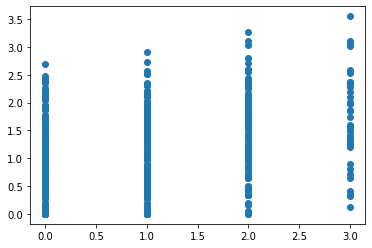

In [31]:
import matplotlib.pyplot as plt

#create scatterplot
plt.scatter(targets_untr,preds_untr)

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target_int, pred_int)

array([[118,  71,  35,   1,   0],
       [ 31,  72,  36,   5,   0],
       [ 20,  31,  34,   7,   0],
       [  6,  12,  16,   5,   1],
       [  0,   0,   0,   0,   0]])

In [38]:
from sklearn.metrics import classification_report
target_names = [0,1,2,3]
print(classification_report(target_int, pred_int))

              precision    recall  f1-score   support

         0.0       0.67      0.52      0.59       225
         1.0       0.39      0.50      0.44       144
         2.0       0.28      0.37      0.32        92
         3.0       0.28      0.12      0.17        40
         4.0       0.00      0.00      0.00         0

    accuracy                           0.46       501
   macro avg       0.32      0.30      0.30       501
weighted avg       0.49      0.46      0.46       501



In [34]:
41

41

In [35]:
tar=df['targets'].value_counts()

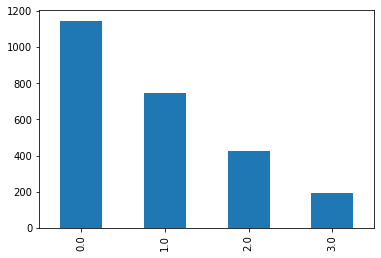

In [36]:
tar.plot(kind='bar')

In [37]:
# df.loc[df["Sizing_bins"] == 6, "Sizing_cpy"].plot(kind='hist')